In [37]:
import pandas as pd
import numpy as np

import tensorflow as tf
import numpy as np
import time
import os
import random
import cv2

from keras.utils import Sequence
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
from sklearn.model_selection import train_test_split

In [38]:
INPUT_CSV_FILE = "./../assets/dataset/dataset.csv"
DATASET_ROOT_DIR = "./../assets/dataset/"

BATCH_SIZE = 32
IMG_SIZE = (94, 24)
NUM_CHANNELS = 3

CHARS = [
         '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
         'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
         'L', 'M', 'N','O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
         'W', 'X', 'Y', 'Z'
         ]
label_len = 7


CHARS_DICT = [[char,float(i)] for i, char in enumerate(CHARS)]

NUM_CHARS = len(CHARS)
lb.fit(CHARS)

LabelBinarizer()

In [39]:
input_df = pd.read_csv(INPUT_CSV_FILE, header=None,names=['Image', 'label'])
input_df["Image"] = input_df["Image"].apply(lambda s: ('hdr/' if list(str(s).split('/')[0].split('_')[1])[0] == 'h' else "normal/") +s) 
input_df.head()

,Image,label
0,normal/crop_m1/I00000.png,9B52145
1,hdr/crop_h1/I00000.png,9B52145
2,normal/crop_m1/I00001.png,6B94558
3,hdr/crop_h1/I00001.png,6B94558
4,normal/crop_m1/I00002.png,8B90164


In [48]:
from collections import Counter
Counter(input_df["label"].str.cat())

Counter({'9': 364,
         'B': 548,
         '5': 360,
         '2': 348,
         '1': 420,
         '4': 386,
         '6': 362,
         '8': 416,
         '0': 338,
         'C': 28,
         '3': 354,
         'D': 10,
         '7': 366,
         'Z': 60,
         'N': 6,
         'E': 18,
         'L': 12,
         'A': 44,
         'M': 22,
         'S': 10,
         'X': 6,
         'T': 22,
         'J': 14,
         'G': 2,
         'F': 6,
         'R': 2,
         'V': 4,
         'H': 6,
         'P': 6,
         'I': 12,
         'K': 2})

In [117]:
input_df["label"].apply(lambda s: len(s)).value_counts()

7    646
5      4
6      2
Name: label, dtype: int64

## Drop outliers

In [129]:
input_df[input_df["label"].apply(lambda s: len(s)) == 7]

,Image,label
0,normal/crop_m1/I00000.png,9B52145
1,hdr/crop_h1/I00000.png,9B52145
2,normal/crop_m1/I00001.png,6B94558
3,hdr/crop_h1/I00001.png,6B94558
4,normal/crop_m1/I00002.png,8B90164
...,...,...
647,hdr/crop_h4/I00084.png,2B90178
648,normal/crop_m4/I00085.png,7B59839
649,hdr/crop_h4/I00085.png,7B59839
650,normal/crop_m4/I00086.png,7B11123


In [40]:
def encode_label(s):
    return lb.transform(list(s))
def decode_sparse_label(sparse):
    return lb.inverse_transform(sparse)

In [109]:
class OCRTextImageGenerator(Sequence):
    def __init__(
        self, 
        df, 
        batch_size=32,
        root_dir="./../assets/dataset/", 
        img_size=( 348,129), 
        num_channels=3,
         label_len=7,
         shuffle=False):
        print(" found ",str(len(df["Image"]))," image files")
        self.filenames = df["Image"]
        self.labels = df["label"]
        self._root_dir = root_dir
        self._batch_size = batch_size
        self._num_channels = num_channels
        self._label_len = label_len
        self._img_size = img_size

        self._num_examples = 0
        self._num_epoches = 0
        self._shuffle = shuffle
        self._indices = np.arange(len(self.filenames))
        self._n = 0
        self._max = self.__len__()


    def __len__(self):
        return int(len(self.filenames) / self._batch_size)

    def __getitem__(self, idx):
        if self._shuffle:
            np.random.shuffle(self._indices)
        indices = self._indices[idx * self._batch_size:(idx + 1) * self._batch_size]
        batch_filenames = self.filenames[indices]
        batch_labels = self.labels[indices]

        batch_filenames = [os.path.join(self._root_dir,filename) for filename in batch_filenames]
        batch_labels = [encode_label(batch_label) for batch_label in batch_labels]

        batch_file_images = [cv2.imread(filename) for filename in batch_filenames]
        batch_file_images = [ cv2.resize(img,  self._img_size, interpolation=cv2.INTER_CUBIC) for img in batch_file_images]
        batch_file_images = [ img * 255.0 for img in batch_file_images]
        batch_file_images = [image.astype(np.uint8) for image in batch_file_images]

        batch_file_images = np.asarray(batch_file_images).astype(np.float32)
        batch_labels = np.asarray(batch_labels).astype(np.float32)

        return batch_file_images, batch_labels

    def __next__(self):
        if self._n >= self._max:
           self._n = 0
        else:
           self._n += 1
        result = self.__getitem__(self._n)
        
        return result

    def on_epoch_end(self):
        self._indices = np.random.shuffle(self._indices)

In [110]:
def visualize(data_gen):
    images,labels = next(data_gen)
    w = 10
    h = 10
    fig = plt.figure(figsize=(9, 13))
    columns = 4
    rows = 4

    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns*rows):
        img = images[i]
        label = labels[i]
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(" ".join(decode_sparse_label(label)))  # set title
        plt.imshow((img * 255).astype(np.uint8))


    plt.show()  # finally, render the plot


In [111]:
train_df,test_df = train_test_split(input_df, test_size=0.20, random_state=42,shuffle=True)
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
train_df.shape,test_df.shape

((521, 3), (131, 3))

 found  521  image files


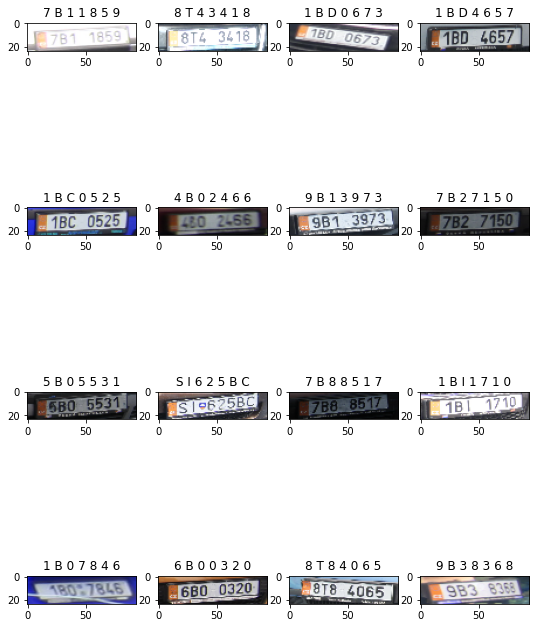

In [112]:
dataset = OCRTextImageGenerator(train_df, batch_size=32,img_size=IMG_SIZE,root_dir="./../assets/dataset/", num_channels=3,label_len=7,shuffle=True)

visualize(dataset)

In [106]:

images,labels = next(dataset)
print(images.shape,labels.shape)

(32, 24, 94, 3) (32, 7, 36)
